Importing, constants and loading the data.



In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from torch.utils.data import TensorDataset
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import confusion_matrix
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import random
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import normalized_mutual_info_score
from sklearn.metrics import silhouette_score
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors
from google.colab import drive
drive.mount('/content/drive')

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', DEVICE)

transform = transforms.Compose([transforms.ToTensor()])
train_full = datasets.FashionMNIST(root='.', train=True, download=True, transform=transform)
test_full  = datasets.FashionMNIST(root='.', train=False, download=True, transform=transform)

train_loader = DataLoader(train_full, batch_size=256, shuffle=True)
test_loader  = DataLoader(test_full, batch_size=256, shuffle=False)

# create flat numpy arrays for methods that need them (SVD, sklearn clustering)
def loader_to_numpy(loader):
    X_list, y_list = [], []
    for imgs, labels in loader:
        imgs = imgs.view(imgs.size(0), -1).numpy()
        X_list.append(imgs)
        y_list.append(labels.numpy())
    X = np.vstack(X_list)
    y = np.hstack(y_list)
    return X, y

X_train, y_train = loader_to_numpy(train_loader)
X_test,  y_test  = loader_to_numpy(test_loader)

print('Data shapes (train/test/all):', X_train.shape, X_test.shape)

# FashionMNIST classes, e.g.:
# 0 = T-shirt/top, 1 = Trouser, 2 = Pullover, 3 = Dress,
# 4 = Coat, 5 = Sandal, 6 = Shirt, 7 = Sneaker, 8 = Bag, 9 = Boot

class_names = [
    'T-shirt/top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot'
]



Mounted at /content/drive
Device: cpu


100%|██████████| 26.4M/26.4M [00:01<00:00, 16.8MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 268kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 4.95MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 25.0MB/s]


Data shapes (train/test/all): (60000, 784) (10000, 784)


# **Data Preparation**

In [3]:
SELECTED_CLASSES = [0, 1, 3, 6, 7, 8, 9]
train_flags = np.isin(y_train, SELECTED_CLASSES) #Creates a bullean list, which is true when the object belongs to one of the classes.
test_flags  = np.isin(y_test, SELECTED_CLASSES) #The same as above.

X_train_filtered = X_train[train_flags] #Filtering based on the bullean list above.
y_train_filtered = y_train[train_flags]

X_test_filtered  = X_test[test_flags]
y_test_filtered  = y_test[test_flags]


# **Implementing Mehtods**

# **Dimension Reduction**

**SVD**




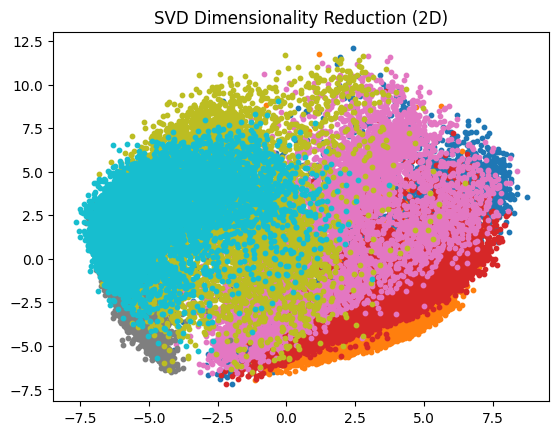

In [4]:
#Centering the means:

X_train_mean_vector = np.mean(X_train_filtered, axis=0)     # column means
X_train_centered = X_train_filtered - X_train_mean_vector         # subtract mean from each sample

X_test_centered = X_test_filtered - X_train_mean_vector         # subtract the train mean from each sample.
# We substract the train mean and not the test mean because in the real world, when we get a new image (i.e. from the test), we don't know the mean of all future objects.


#Performing the SVD:

k = 32  # number of components
svd = TruncatedSVD(n_components=k, random_state=RANDOM_SEED)
Z_train = svd.fit_transform(X_train_centered)
Z_test = svd.transform(X_test_centered)

# Reduce to 2D
svd_2d = TruncatedSVD(n_components=2, random_state=RANDOM_SEED)
Z_2d = svd_2d.fit_transform(X_train_centered)

for digit in range(10):
  idx = y_train_filtered == digit
  plt.scatter(Z_2d[idx,0], Z_2d[idx,1], s=10, label=str(digit))
plt.title("SVD Dimensionality Reduction (2D)")
plt.show()

# Z now contains the k-dimensional embedding

**AE**

We implemented a Convolutional Autoencoder to better capture the spatial patterns inherent in image data. By using convolutional layers instead of linear ones, the model achieves higher reconstruction quality and learns a more robust representation of the digits.

In [46]:
X_train_tensor = torch.tensor(X_train_filtered).float()
y_train_tensor = torch.tensor(y_train_filtered).long()

X_test_tensor = torch.tensor(X_test_filtered).float()
y_test_tensor = torch.tensor(y_test_filtered).long()


train_loader = DataLoader(
    TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True
)

test_loader = DataLoader(
    TensorDataset(X_test_tensor, y_test_tensor), batch_size=64, shuffle=False
)



IMG_SIZE = 28 * 28
HID_DIM_AE = 64

class ConvAE(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()

        # Encoder: 28x28 -> 14x14 -> 7x7
        self.encoder = nn.Sequential(
            # Input: (1, 28, 28)
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1), # Output: (16, 14, 14)
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1), # Output: (32, 7, 7)
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(32 * 7 * 7, latent_dim)
        )

        # Decoder: latent -> 7x7 -> 14x14 -> 28x28
        self.decoder_input = nn.Linear(latent_dim, 32 * 7 * 7)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1), # Output: (16, 14, 14)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1), # Output: (1, 28, 28)
        )

    def forward(self, x):
        # Ensure input is (Batch, 1, 28, 28)
        if len(x.shape) == 2:
            x = x.view(-1, 1, 28, 28)

        z = self.encoder(x)

        x_rec = self.decoder_input(z)
        x_rec = x_rec.view(-1, 32, 7, 7)
        x_rec = self.decoder(x_rec)

        # Flatten back for the loss function if needed
        return x_rec.view(x_rec.size(0), -1), z




def learning_loop(model, optimizer, train_loader, val_loader, criterion,
                  is_vae=False, epochs=10, verbose=1):

    train_losses, test_losses = [], []

    for ep in range(epochs):
        model.train()
        total_train = 0
        for xb, _ in train_loader:
            optimizer.zero_grad()
            if is_vae:
                recon, z, mu, logvar = model(xb)
                loss = criterion(recon, xb, mu, logvar)
            else:
                recon, z = model(xb)
                loss = criterion(recon, xb)

            loss.backward()
            optimizer.step()
            total_train += loss.item()

        train_losses.append(total_train)

        # ----- Test -----
        model.eval()
        total_test = 0
        with torch.no_grad():
            for xb, _ in test_loader:
                if is_vae:
                    recon, z, mu, logvar = model(xb)
                    loss = criterion(recon, xb, mu, logvar)
                else:
                    recon, z = model(xb)
                    loss = criterion(recon, xb)
                total_test += loss.item()

        test_losses.append(total_test)
        if ep % verbose == 0:
          print(f"Epoch {ep+1}/{epochs} - Train {total_train:.1f} - Test {total_test:.1f}")

    return train_losses, test_losses

In [48]:
def ae_loss(recon, x):
    return nn.functional.mse_loss(recon, x, reduction="sum")

ae_dim2 = ConvAE(latent_dim=2)
ae_dim32 = ConvAE(latent_dim=32)
ae_optimizer_dim2 = optim.Adam(ae_dim2.parameters(), lr=0.001)
ae_optimizer_dim32 = optim.Adam(ae_dim32.parameters(), lr=0.001)
ae_criterion = ae_loss

print("Training AE with dim = 2:")
ae_train_dim2, ae_test_dim2 = learning_loop(ae_dim2, ae_optimizer_dim2, train_loader, test_loader, ae_criterion,
                  is_vae=False, epochs=60, verbose=5)

print("Training AE with dim = 32:")
ae_train_dim32, ae_test_dim32 = learning_loop(ae_dim32, ae_optimizer_dim32, train_loader, test_loader, ae_criterion,
                  is_vae=False, epochs=60, verbose=5)

Training AE with dim = 2:
Epoch 1/60 - Train 1512907.1 - Test 199280.8
Epoch 6/60 - Train 1030897.9 - Test 171434.8
Epoch 11/60 - Train 996824.3 - Test 167100.5
Epoch 16/60 - Train 980717.6 - Test 165680.8
Epoch 21/60 - Train 970296.7 - Test 162892.4
Epoch 26/60 - Train 962474.6 - Test 161359.2
Epoch 31/60 - Train 956835.5 - Test 161378.6
Epoch 36/60 - Train 951848.9 - Test 160414.8
Epoch 41/60 - Train 948392.9 - Test 159938.2
Epoch 46/60 - Train 944795.2 - Test 159450.8
Epoch 51/60 - Train 942355.8 - Test 159549.4
Epoch 56/60 - Train 939955.9 - Test 158955.8
Training AE with dim = 32:
Epoch 1/60 - Train 1008037.1 - Test 90780.5
Epoch 6/60 - Train 364850.4 - Test 59494.8
Epoch 11/60 - Train 315917.4 - Test 53151.0
Epoch 16/60 - Train 295369.9 - Test 49484.2
Epoch 21/60 - Train 284457.8 - Test 47913.0
Epoch 26/60 - Train 277997.6 - Test 46971.2
Epoch 31/60 - Train 273204.4 - Test 46597.5
Epoch 36/60 - Train 269816.9 - Test 45545.2
Epoch 41/60 - Train 267357.9 - Test 45300.1
Epoch 46/60 

Saving the parametrs of the model in a personal drive:

In [49]:
path_dim2 = "/content/drive/MyDrive/Unsupervised_Project/ae_dim2.pth"
path_dim32 = "/content/drive/MyDrive/Unsupervised_Project/ae_dim32.pth"

torch.save(ae_dim2.state_dict(), path_dim2)
torch.save(ae_dim32.state_dict(), path_dim32)

Loading the model's parameters:

In [50]:
ae_dim2 = ConvAE(latent_dim=2)
ae_dim32 = ConvAE(latent_dim=32)

ae_dim2.load_state_dict(torch.load(path_dim2))
ae_dim32.load_state_dict(torch.load(path_dim32))


ae_dim2.eval()
ae_dim32.eval()

print("Models loaded successfully!")

Models loaded successfully!


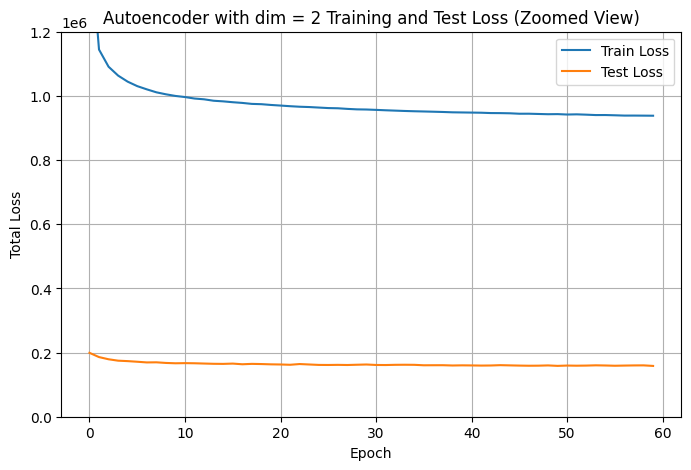

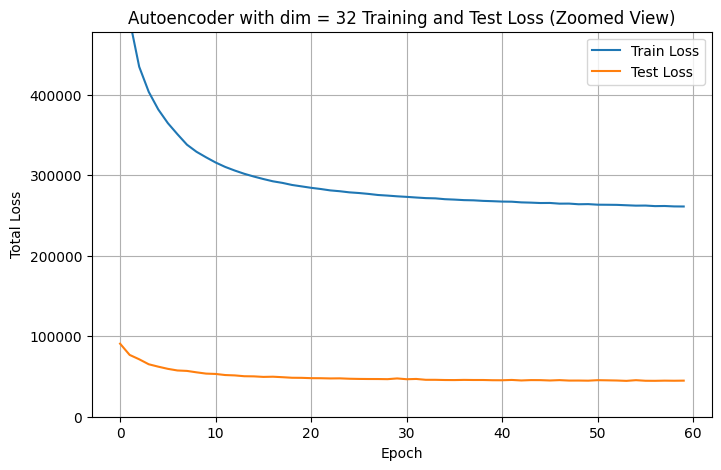

In [51]:
def draw_losses(train_losses, test_losses,dim):
    plt.figure(figsize=(8,5))

    plt.plot(train_losses, label="Train Loss")
    plt.plot(test_losses, label="Test Loss")


    upper_limit = max(train_losses[2:]) * 1.1 # The first two losses are huge, thats why we don't want to show them in the graph
    plt.ylim(0, upper_limit)

    plt.xlabel("Epoch")
    plt.ylabel("Total Loss")
    plt.title(f"Autoencoder with dim = {dim} Training and Test Loss (Zoomed View)")
    plt.legend()
    plt.grid(True)
    plt.show()


draw_losses(ae_train_dim2, ae_test_dim2,2)


draw_losses(ae_train_dim32, ae_test_dim32,32)

The pictures and their reconstruction with dim = 2 



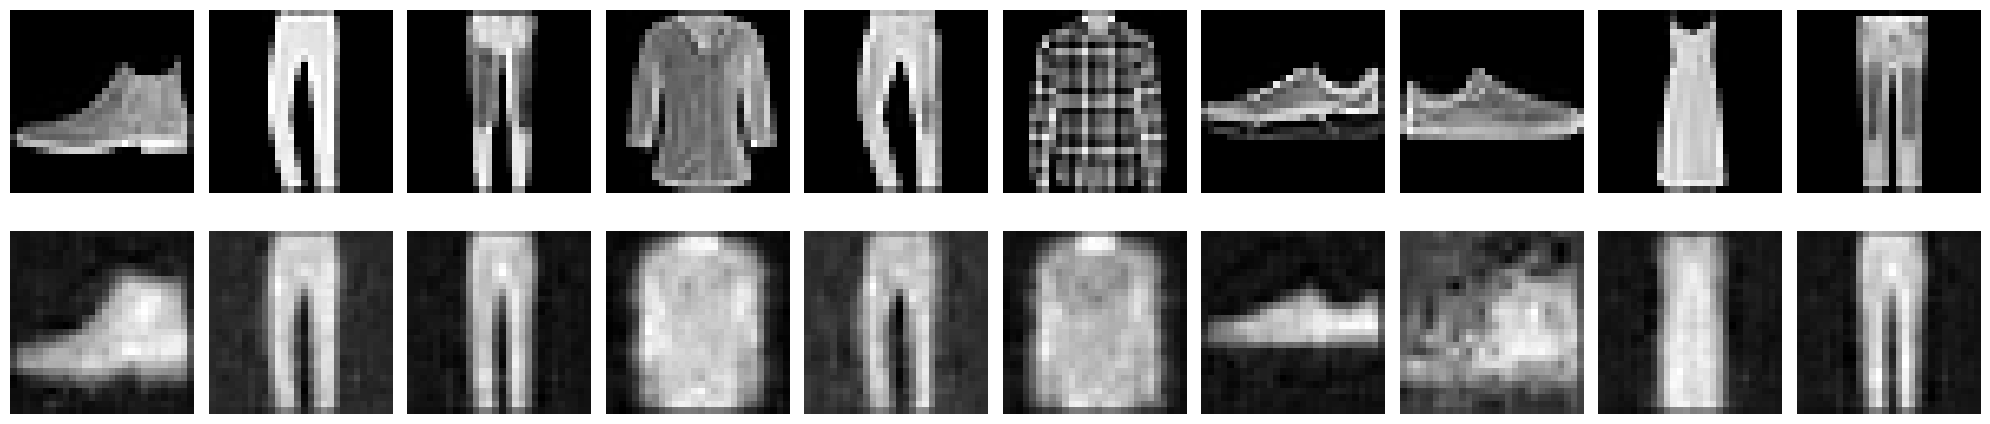

The pictures and their reconstruction with dim = 32 



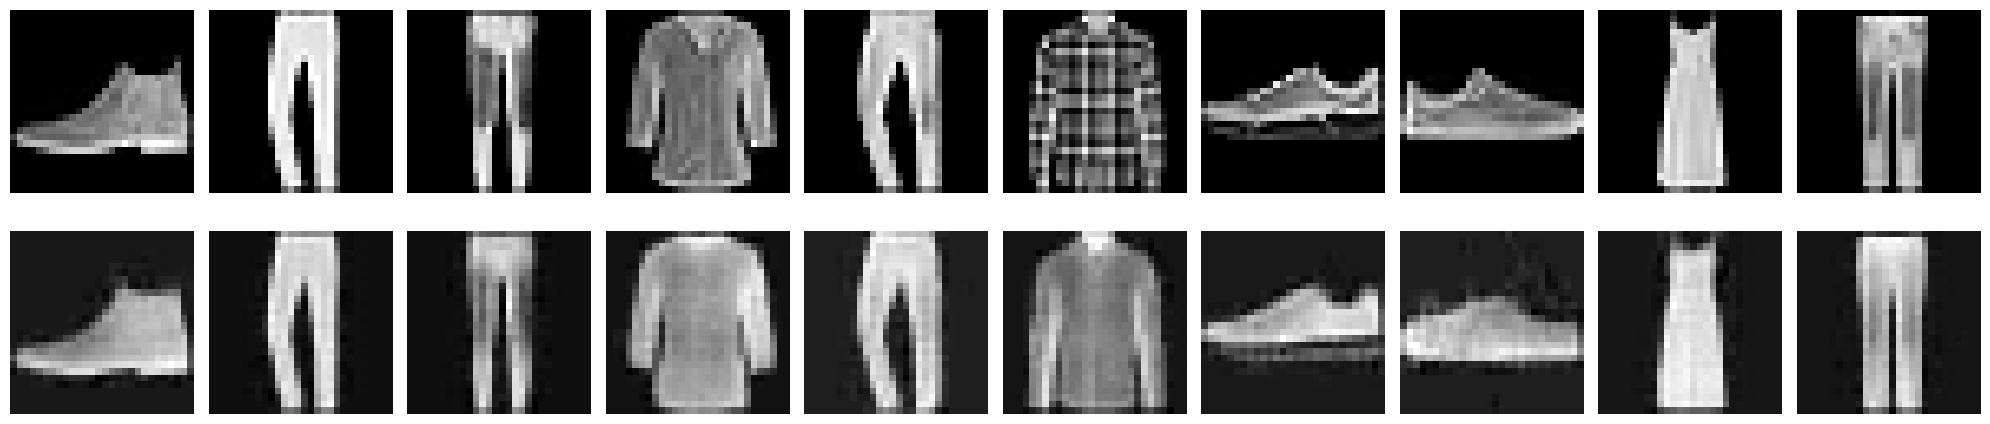

In [61]:
def plot_comparisons(model, test_tensor, n=10):
    model.eval()
    fig, axes = plt.subplots(2, n, figsize=(20, 5))

    with torch.no_grad():
        for i in range(n):
            original = test_tensor[i].view(1, -1)
            reconstructed, z = model(original)

            # presenting the source images
            axes[0, i].imshow(original.reshape(28, 28).cpu().numpy(), cmap='gray')
            axes[0, i].axis('off')
            if i == 0: axes[0, i].set_ylabel("Original", size=15)

            # preseting the reconstraction
            axes[1, i].imshow(reconstructed.reshape(28, 28).cpu().numpy(), cmap='gray')
            axes[1, i].axis('off')
            if i == 0: axes[1, i].set_ylabel("Reconstructed", size=15)


    plt.tight_layout()
    plt.show()

print("The pictures and their reconstruction with dim = 2 \n")
plot_comparisons(ae_dim2, X_test_tensor, n=10)
print("The pictures and their reconstruction with dim = 32 \n")
plot_comparisons(ae_dim32, X_test_tensor, n=10)

We can visually see that the images reconstructed by the autoencoder with dim=2 are heavily blurred and lack distinct details. However, the autoencoder with dim=32 successfully reconstructed the pictures. While they are not perfectly sharp, they are highly understandable, and we can clearly identify which item of clothing is in each picture.

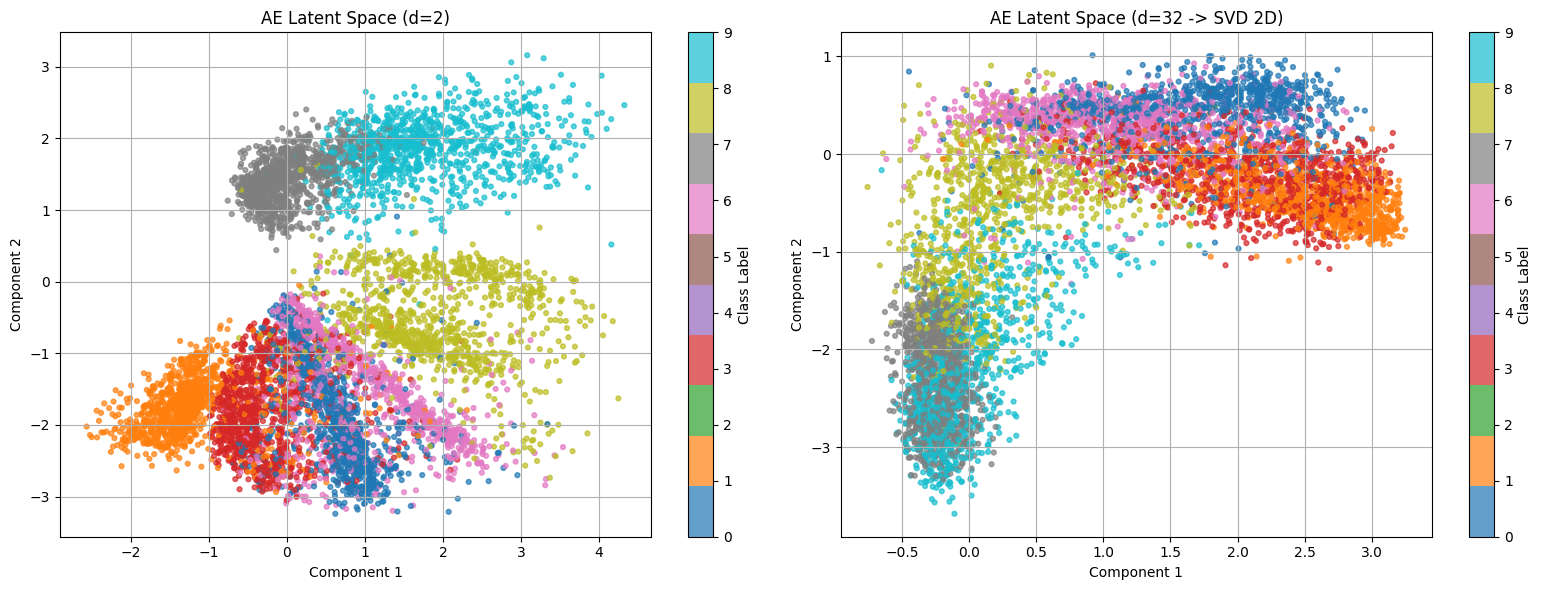

In [54]:
def plot_latent_on_ax(model, loader, title, ax):
    model.eval()
    zs, labels = [], []

    # Extract latent vectors and true labels from the model
    with torch.no_grad():
        for xb, yb in loader:
            _, z = model(xb)
            zs.append(z.cpu().numpy())
            labels.append(yb.numpy())

    zs = np.vstack(zs)
    labels = np.hstack(labels)

    # Apply SVD for visualization if the latent dimension is greater than 2
    if zs.shape[1] > 2:
        reducer = TruncatedSVD(n_components=2)
        plot_data = reducer.fit_transform(zs)
    else:
        plot_data = zs

    # Plot the 2D representation on the provided axis
    scatter = ax.scatter(plot_data[:, 0], plot_data[:, 1], c=labels, cmap="tab10", s=12, alpha=0.7)
    ax.set_title(title)
    ax.set_xlabel("Component 1")
    ax.set_ylabel("Component 2")
    ax.grid(True)

    return zs, labels, scatter

# Create a figure with two subplots side-by-side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Execute for dim=2 model
zs2, labels2, sc1 = plot_latent_on_ax(ae_dim2, test_loader, "AE Latent Space (d=2)", ax1)
fig.colorbar(sc1, ax=ax1, label="Class Label")

# Execute for dim=32 model (internal SVD reduction to 2D)
zs32, labels32, sc2 = plot_latent_on_ax(ae_dim32, test_loader, "AE Latent Space (d=32 -> SVD 2D)", ax2)
fig.colorbar(sc2, ax=ax2, label="Class Label")

plt.tight_layout()
plt.show()

Let's analyze the results:


Analysis of the 2D Latent Space (d=2):
The 2D latent space projection shows the data forming a somewhat fan-like shape. Visually similar categories overlap, such as the T-shirts (blue) and shirts (pink), as well as the ankle boots (cyan) and sneakers (gray). Apart from the footwear, the other clothing items are not convexly separated, which makes clustering significantly harder for K-Means. This central overlap clearly illustrates the "bottleneck limit" of extreme dimensionality reduction and explains why clustering algorithms struggle to achieve high accuracy on a purely 2D latent space.

Analysis of the 32D Latent Space (Projected to 2D via SVD):
In the projection of the 32D latent space, the data still appears to be heavily overlapping, especially among the T-shirts (blue), shirts (pink), trousers (orange), and dresses (red). However, we suggest that this visual overlap occurs primarily because we had to perform SVD on top of the Autoencoder to squash the 32 dimensions down to a 2D graph. We assume that in the true 32-dimensional space, the data is much better separated, and expect the predicted cluster metrics to reflect a higher accuracy.




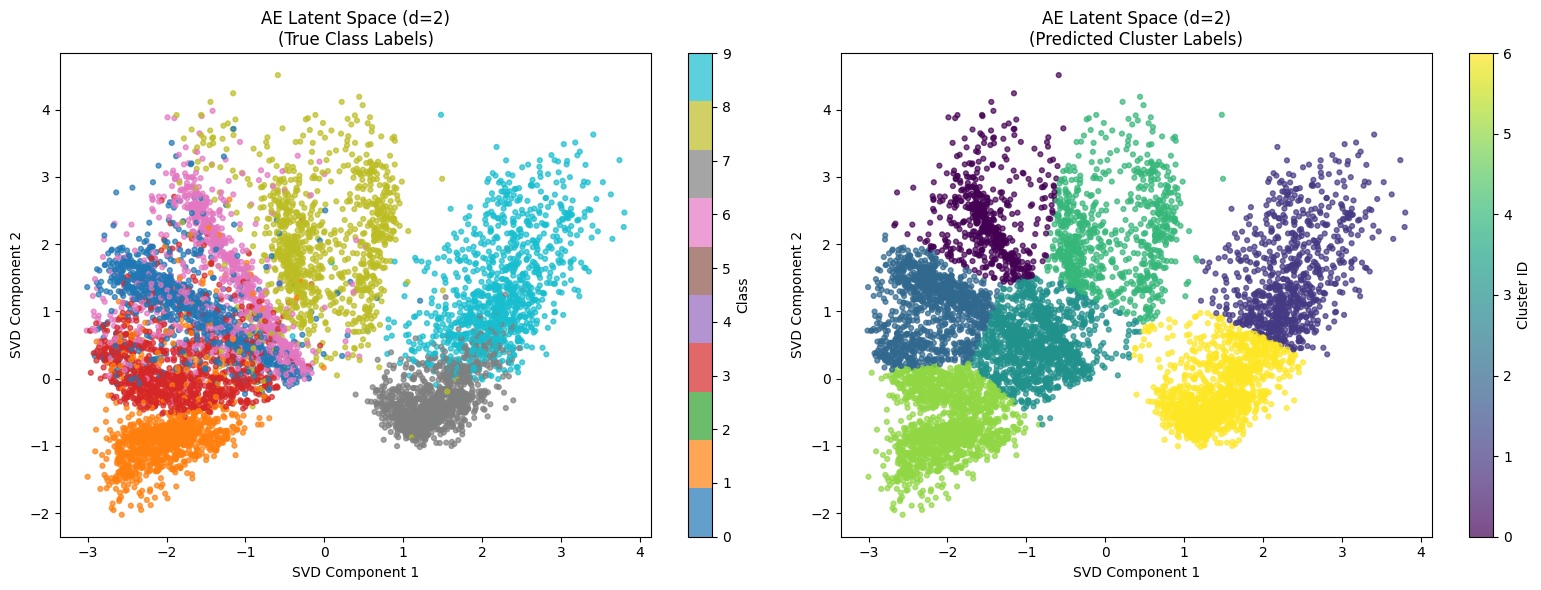

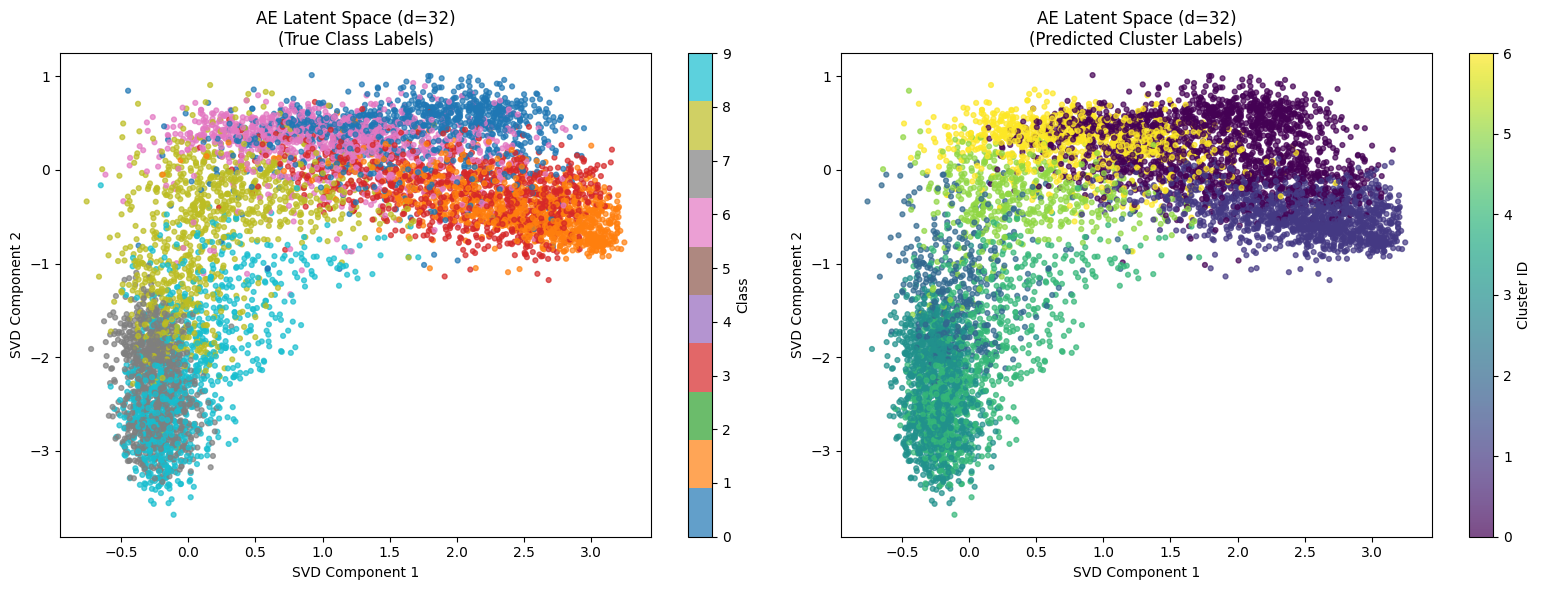

In [56]:
def plot_svd_comparison(latents, true_labels, n_clusters, title):
    # 1. Perform Clustering on the original high-dimensional latent space (e.g., 32D)
    # This ensures K-Means utilizes all learned features before dimensionality reduction.
    kmeans = KMeans(n_clusters=n_clusters, random_state=RANDOM_SEED, n_init=10)
    predicted_labels = kmeans.fit_predict(latents)

    # 2. Reduce dimensions to 2D using SVD for visualization
    # If the input is already 2D, SVD will simply project it.
    svd = TruncatedSVD(n_components=2, random_state=RANDOM_SEED)
    latents_2d = svd.fit_transform(latents)

    # 3. Create side-by-side comparison plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Left Plot: Ground Truth (Real Classes)
    scatter1 = ax1.scatter(latents_2d[:, 0], latents_2d[:, 1],
                           c=true_labels, cmap="tab10", s=12, alpha=0.7)
    ax1.set_title(f"{title}\n(True Class Labels)")
    ax1.set_xlabel("SVD Component 1")
    ax1.set_ylabel("SVD Component 2")
    fig.colorbar(scatter1, ax=ax1, label="Class")

    # Right Plot: Clustering Results (K-Means Output)
    scatter2 = ax2.scatter(latents_2d[:, 0], latents_2d[:, 1],
                           c=predicted_labels, cmap="viridis", s=12, alpha=0.7)
    ax2.set_title(f"{title}\n(Predicted Cluster Labels)")
    ax2.set_xlabel("SVD Component 1")
    ax2.set_ylabel("SVD Component 2")
    fig.colorbar(scatter2, ax=ax2, label="Cluster ID")

    plt.tight_layout()
    plt.show()

# Number of classes in your specific FashionMNIST subset
num_classes = len(SELECTED_CLASSES)

# Execute visualization for the d=2 model
plot_svd_comparison(zs2, labels2, num_classes, "AE Latent Space (d=2)")

# Execute visualization for the d=32 model
plot_svd_comparison(zs32, labels32, num_classes, "AE Latent Space (d=32)")

These graphs illustrate the results of K-Means clustering applied to the $d=2$ and $d=32$ Autoencoder latent spaces.In the $d=2$ graphs, because the space is highly compressed and the data points are dense, the algorithm simply "slices" the data into rigid bands of color. These artificial boundaries do not follow the true distribution of the clothing classes, demonstrating that 2 dimensions are not enough to 'capture the whole picture'.The transition from $d=2$ to $d=32$ dramatically improves clustering performance by providing more mathematical "room" to distinguish between categories. In the strictly 2D space, K-Means produces arbitrary slices that fail to match the true labels. Conversely, the $d=32$ model allows the data to spread out and form overlapping 'clouds' of distinct features. Because these higher-dimensional clusters are more spatially separated, K-Means can more accurately identify the natural boundaries of the clothing items, resulting in a much higher alignment between predicted labels and true classes.However, there are also notable similarities between the two configurations:In both dimensionalities, certain classes like T-shirts (0) and shirts (6) remain mingled with each other. This makes logical sense because these items share highly similar visual features. Similarly, ankle boots (9) and sneakers (7), as well as dresses (3) and trousers (1), show significant overlap.

Visualizing Latent Path for Dim = 2


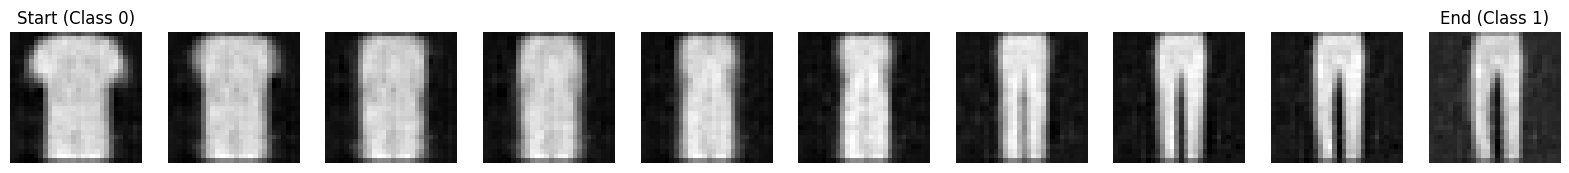

Visualizing Latent Path for Dim = 32


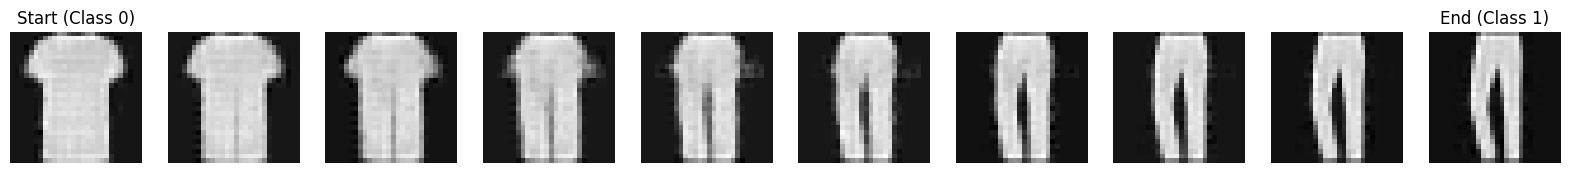

In [57]:
def visualize_latent_path(model, test_loader, class_a=3, class_b=7, n_steps=10):
    model.eval()

    # 1. Get representative samples from the data loader
    images, labels = next(iter(test_loader))

    # Find the first index of each requested class
    idx_a = (labels == class_a).nonzero(as_tuple=True)[0][0]
    idx_b = (labels == class_b).nonzero(as_tuple=True)[0][0]

    img_a = images[idx_a].unsqueeze(0)
    img_b = images[idx_b].unsqueeze(0)

    with torch.no_grad():
        # 2. Encode images into Latent Space (z)
        _, z_a = model(img_a)
        _, z_b = model(img_b)

        # 3. Create a linear path (interpolation) between z_a and z_b
        alphas = torch.linspace(0, 1, n_steps).to(z_a.device).view(-1, 1)
        interpolated_z = (1 - alphas) * z_a + alphas * z_b

        # 4. Reconstruct images from the interpolated vectors
        if hasattr(model, 'decoder_input'):
            # Path for ConvAE: apply linear mapping and reshape to 4D for ConvTranspose2d
            x = model.decoder_input(interpolated_z)
            x = x.view(-1, 32, 7, 7)
            decoded_path = model.decoder(x)
        else:
            # Path for standard Linear AE
            decoded_path = model.decoder(interpolated_z)

    # 5. Visualize the transition
    plt.figure(figsize=(20, 4))
    for i in range(n_steps):
        plt.subplot(1, n_steps, i + 1)
        # Ensure correct image shape (28x28) for display
        plt.imshow(decoded_path[i].view(28, 28).cpu().numpy(), cmap='gray')
        plt.axis('off')
        if i == 0: plt.title(f"Start (Class {class_a})")
        if i == n_steps - 1: plt.title(f"End (Class {class_b})")
    plt.show()

# Execution example
print("Visualizing Latent Path for Dim = 2")
visualize_latent_path(ae_dim2, test_loader, class_a=0, class_b=1)

print("Visualizing Latent Path for Dim = 32")
visualize_latent_path(ae_dim32, test_loader, class_a=0, class_b=1)

Comparison: $d=2$ vs. $d=32$

 The Latent Path reveals the true difference: $d=32$ produces sharper images and smoother transitions. The $d=2$ path is more blurry and generalized, proving that the narrow bottleneck discards too much structural information compared to the $d=32$ model.
Further more, the reconstructed picutres from the AE with $d=32$ look like trousers eralier then the one with $d=2$.

# **Evaluation of the methods and accuracy**

**ARI**

In [6]:
def ari(true,pred):
  return adjusted_rand_score(true, pred)

**NMI**

In [7]:
def nmi(true,pred):
  return normalized_mutual_info_score(true, pred)

**Silhouette**

In [8]:
def silhouette(X,pred):
  return silhouette_score(X,pred)

**Accuracy via optimal label matching**

In [9]:
def cluster_acc(y_true, y_pred):
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    # Use linear_sum_assignment (Hungarian algorithm) to find optimal matching
    row_ind, col_ind = linear_sum_assignment(w.max() - w)
    return w[row_ind, col_ind].sum() / y_pred.size

# **Clustering Algorithms:**

**K-means**

In [10]:
def K_means(X, k):
  kmeans = KMeans(n_clusters=k, random_state=RANDOM_SEED)
  labels_km = kmeans.fit_predict(X)
  return labels_km


In [11]:
def gmm(X, n):
  gmm = GaussianMixture(n_components=n, covariance_type='full', random_state=RANDOM_SEED)
  gmm.fit(X)
  labels_gmm = gmm.predict(X)
  return labels_gmm

In [12]:
def dbscan(X, epsilon, n):
  dbscan = DBSCAN(eps=epsilon, min_samples=n)
  labels_dbscan = dbscan.fit_predict(X)
  return labels_dbscan


**Running the K_means, GMM, DBSCAN algorithms on the data after SVD:**

In [13]:
labels_km_svd = K_means(Z_test, 7)
labels_gmm_svd = gmm(Z_test, 7)

In [237]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.metrics import adjusted_rand_score

def find_and_print_best_eps(X_scaled, y_true, name):
    best_eps = 0.01
    best_ari = -1

    print(f"Searching for the best EPS for {name} (Resolution: 0.01)...")

    # סורק מ-0.01 עד 1.50
    for test_eps in np.arange(0.01, 1.51, 0.01):
        dbscan_model = DBSCAN(eps=test_eps, min_samples=10)
        test_labels = dbscan_model.fit_predict(X_scaled)

        # בודק כמה אשכולות אמיתיים נוצרו (ללא הרעש)
        n_clusters = len(np.unique(test_labels)) - (1 if -1 in test_labels else 0)

        if n_clusters > 1:
            current_ari = adjusted_rand_score(y_true, test_labels)

            # שומר את התוצאה הכי טובה
            if current_ari > best_ari:
                best_ari = current_ari
                best_eps = test_eps

    if best_ari == -1:
        print(f"--> Failed to find valid clusters for {name}.")
    else:
        print(f"--> WINNER for {name}: EPS = {best_eps:.2f} (ARI Score = {best_ari:.4f})\n")

# הרצה על הנתונים של ה-SVD
find_and_print_best_eps(Z_test_scaled, y_true_final, "SVD")

# הרצה על הנתונים של ה-Autoencoder
find_and_print_best_eps(X_ae_scaled, y_true_final, "Autoencoder")

Searching for the best EPS for SVD (Resolution: 0.01)...
--> Failed to find valid clusters for SVD.
Searching for the best EPS for Autoencoder (Resolution: 0.01)...
--> WINNER for Autoencoder: EPS = 1.49 (ARI Score = 0.0001)



In [245]:
epsilon = 2.88149988651275656975
N = 10
labels_dbscan_svd = dbscan(Z_test, epsilon, N)

# **Visualzing K-means VS DBSCAN VS GMM after SVD**

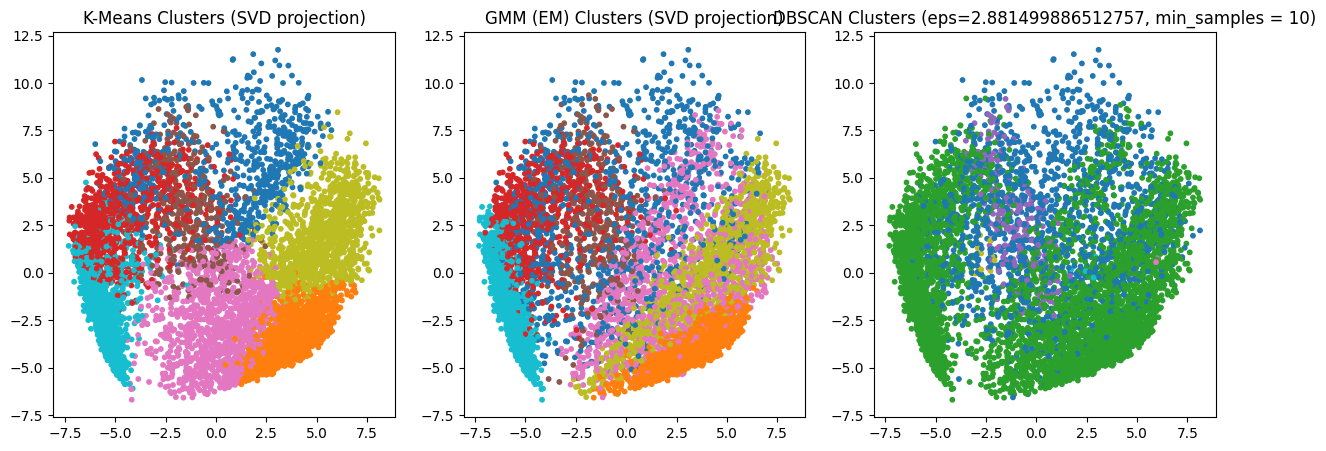

In [246]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1: K-Means
axs[0].scatter(Z_test[:,0], Z_test[:,1], c=labels_km_svd, cmap='tab10', s=10)
axs[0].set_title("K-Means Clusters (SVD projection)")

# Plot 2: GMM
axs[1].scatter(Z_test[:,0], Z_test[:,1], c=labels_gmm_svd, cmap='tab10', s=10)
axs[1].set_title("GMM (EM) Clusters (SVD projection)")

# Plot 3: DBSCAN
# We use 'labels_dbscan' from the previous step
axs[2].scatter(Z_test[:,0], Z_test[:,1], c=labels_dbscan_svd, cmap='tab10', s=10)
axs[2].set_title(f"DBSCAN Clusters (eps={epsilon}, min_samples = {N})")

# Note: in DBSCAN, the color 'black' or the lowest value in tab10
# usually represents the noise (-1) points.

plt.show()

# The results:

**Running the K_means, GMM, DBSCAN algorithms on the data after AE:**

We have seen that when the latent dimension is 32, the ae gives better results than when the latent dim is 2, thus we will use the ae_dim32:

In [247]:
import pandas as pd
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

data = []
dimension_reductions = ['SVD', 'AE']
clusterizations = ['KMeans', 'GMM', 'DBSCAN']

for dr in dimension_reductions:
    for cl in clusterizations:
        data.append({
            'Dimension Reduction': dr,
            'Clusterization': cl,
            'ARI': '?',
            'NMI': '?',
            'Sil': '?',
            'ACC': '?',
        })

df = pd.DataFrame(data)

y_true_final = y_test_filtered
N_CLUSTERS = 7

# SVD Processing
X_train_mean_vector = np.mean(X_train_filtered, axis=0)
X_train_centered = X_train_filtered - X_train_mean_vector
X_test_centered = X_test_filtered - X_train_mean_vector
svd = TruncatedSVD(n_components=32, random_state=RANDOM_SEED)
svd.fit(X_train_centered)
Z_test = svd.transform(X_test_centered)

scaler_svd = StandardScaler()
Z_test_scaled = scaler_svd.fit_transform(Z_test)

# AE Processing
X_ae = zs32
scaler_ae = StandardScaler()
X_ae_scaled = scaler_ae.fit_transform(X_ae)

assert X_ae.shape[0] == y_true_final.size, f"Mismatch: AE has {X_ae.shape[0]} samples, but Labels have {y_true_final.size}"

for index, row in df.iterrows():
    dr_type = row['Dimension Reduction']
    algo = row['Clusterization']

    if dr_type == 'AE':
        current_X = X_ae
        current_X_scaled = X_ae_scaled
    else:
        current_X = Z_test
        current_X_scaled = Z_test_scaled

    if algo == 'KMeans':
        labels = K_means(current_X, k=N_CLUSTERS)
        X_eval = current_X
    elif algo == 'GMM':
        labels = gmm(current_X, n=N_CLUSTERS)
        X_eval = current_X
    elif algo == 'DBSCAN':
        neighbors = NearestNeighbors(n_neighbors=10)
        neighbors_fit = neighbors.fit(current_X_scaled)
        distances, _ = neighbors_fit.kneighbors(current_X_scaled)
        dist_k = np.sort(distances[:, 9])


        labels = dbscan(current_X_scaled, epsilon, n=10)
        X_eval = current_X_scaled

    acc_val = cluster_acc(y_true_final, labels)
    ari_val = ari(y_true_final, labels)
    nmi_val = nmi(y_true_final, labels)

    n_found = len(np.unique(labels)) - (1 if -1 in labels else 0)
    if n_found > 1:
        sil_val = silhouette(X_eval, labels)
    else:
        sil_val = 0.0

    df.at[index, 'ACC'] = round(acc_val, 4)
    df.at[index, 'ARI'] = round(ari_val, 4)
    df.at[index, 'NMI'] = round(nmi_val, 4)
    df.at[index, 'Sil'] = round(sil_val, 4)

display(df)

,Dimension Reduction,Clusterization,ARI,NMI,Sil,ACC
0,SVD,KMeans,0.4376,0.5514,0.241,0.6126
1,SVD,GMM,0.4748,0.605,0.1696,0.6429
2,SVD,DBSCAN,0.0768,0.1312,-0.0805,0.2567
3,AE,KMeans,0.5879,0.6711,0.1964,0.7677
4,AE,GMM,0.6499,0.7093,0.1641,0.8194
5,AE,DBSCAN,0.2035,0.4114,-0.0065,0.413


# Project Conclusion: Clustering FashionMNIST

 This analysis evaluates the effectiveness of different dimensionality reduction and clustering combinations on the FashionMNIST dataset. By comparing performance metrics and latent space visualizations, we can conclude that the Autoencoder (AE) combined with Gaussian Mixture Models (GMM) provides the most robust solution for identifying clothing categories.

 1. Dimensionality Reduction: AE vs. SVD:
 The results demonstrate that the Autoencoder is significantly more effective than Truncated SVD for this dataset.
 * Accuracy Improvement: The AE achieved a maximum accuracy of 81.2% (with GMM), whereas SVD reached only 64.29% (with GMM as well).
 * Feature Representation: While SVD captures linear variance, the AE's ability to learn non-linear patterns allowed for better class separation.
 * Visual Evidence: Visualizations show that the $d=2$ latent space is heavily compressed and overlapping. Moving to a $d=32$ space allowed classes like "Trousers" and "Sneakers" to form distinct islands, making them easier to cluster.

 2. Clustering Algorithm Evaluation: The choice of clustering algorithm had a major impact on the final metrics.
 * GMM and KMeans: Both algorithms performed well, but GMM consistently outperformed KMeans in all  (apart from the Sil test), likely due to its flexibility in handling clusters with different shapes and densities.
 * DBSCAN Failure: DBSCAN performed the most poorly across the board, yielding accuracies of approximately 40% and negative Silhouette scores. This failure suggests that even in the $d=32$ space, the density transitions between clothing classes were not sharp enough for a density-based approach to succeed without further parameter tuning.